In [3]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
!pip install tensorflow
!pip install keras
!pip install protobuf
!pip install grpcio
!pip install h5py
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow
import keras
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import json
import re
import math
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [4]:
# reload from pickle checkpoint
with open('pickle-folder/tsla_week2_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.head(1000)

,avg_price,compound_sentiment,tweet_count,trade_volume
0,,,,
2020-05-20 05:01:00,808.01000,0.000000,2.0,0.0
2020-05-20 05:02:00,808.01000,0.146800,3.0,0.0
2020-05-20 05:03:00,808.01000,0.000000,1.0,0.0
2020-05-20 05:04:00,808.01000,0.101150,2.0,0.0
2020-05-20 05:05:00,808.01000,0.724500,1.0,0.0
2020-05-20 05:06:00,808.01000,0.724500,0.0,0.0
2020-05-20 05:07:00,808.01000,0.724500,0.0,0.0
2020-05-20 05:08:00,808.01000,0.000000,1.0,0.0
2020-05-20 05:09:00,808.01000,0.000000,0.0,0.0


# LSTM
- 50-dimensionial single layer
- activation = tanh
- epochs = 20
- batch size = 63
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 7s - loss: 0.0328 - val_loss: 0.0077
Epoch 2/20
56/56 - 6s - loss: 0.0094 - val_loss: 0.0037
Epoch 3/20
56/56 - 5s - loss: 0.0058 - val_loss: 0.0026
Epoch 4/20
56/56 - 6s - loss: 0.0034 - val_loss: 0.0029
Epoch 5/20
56/56 - 5s - loss: 0.0019 - val_loss: 0.0033
Epoch 6/20
56/56 - 5s - loss: 0.0013 - val_loss: 0.0023
Epoch 7/20
56/56 - 6s - loss: 0.0011 - val_loss: 0.0015
Epoch 8/20
56/56 - 5s - loss: 9.8084e-04 - val_loss: 9.9654e-04
Epoch 9/20
56/56 - 5s - loss: 9.3494e-04 - val_loss: 6.9055e-04
Epoch 10/20
56/56 - 5s - loss: 9.3100e-04 - val_loss: 5.2660e-04
Epoch 11/20
56/56 - 5s - loss: 9.4698e-04 - val_loss: 4.3894e-04
Epoch 12/20
56/56 - 5s - loss: 9.5735e-04 - val_loss: 3.8217e-04
Epoch 13/20
56/56 - 5s - loss: 9.4730e-04 - val_loss: 3.4275e-04
Epoch 14/20
56/56 - 5s - loss: 9.2072e-04 - val_loss: 3.1647e-04
Epoch 15/20
56/56 - 5s - loss: 8.8806e-04 - val_loss: 2.9967e-04
Epoch 16/20
56/56 

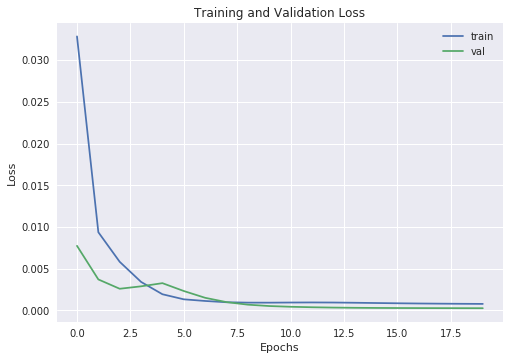

Test RMSE: 1.238
Test RMSE/std_dev: 0.167
Test MAE: 0.709


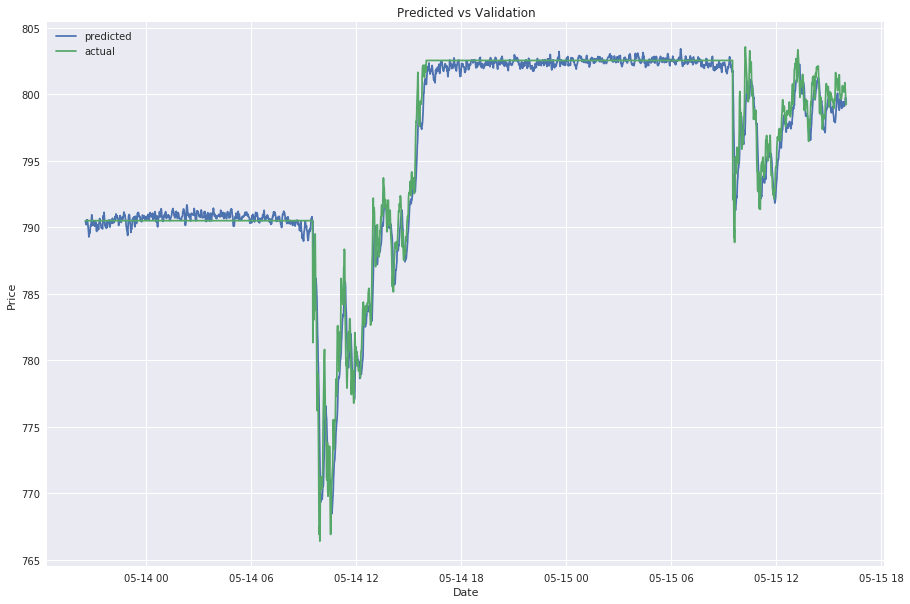

In [107]:
# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[-2610:], y_pred, label='predicted')
    plt.plot(test_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

 # LSTM
 - 64-dimensional single layer
 - activation=tanh
 - epochs = 20
 - batch size = 64
 - 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 7s - loss: 0.0340 - val_loss: 0.0079
Epoch 2/20
56/56 - 6s - loss: 0.0107 - val_loss: 0.0039
Epoch 3/20
56/56 - 6s - loss: 0.0061 - val_loss: 0.0029
Epoch 4/20
56/56 - 6s - loss: 0.0031 - val_loss: 0.0036
Epoch 5/20
56/56 - 6s - loss: 0.0016 - val_loss: 0.0033
Epoch 6/20
56/56 - 6s - loss: 0.0014 - val_loss: 0.0024
Epoch 7/20
56/56 - 5s - loss: 0.0012 - val_loss: 0.0017
Epoch 8/20
56/56 - 6s - loss: 0.0011 - val_loss: 0.0012
Epoch 9/20
56/56 - 6s - loss: 0.0011 - val_loss: 8.9273e-04
Epoch 10/20
56/56 - 6s - loss: 0.0011 - val_loss: 6.7963e-04
Epoch 11/20
56/56 - 6s - loss: 0.0011 - val_loss: 5.3634e-04
Epoch 12/20
56/56 - 6s - loss: 0.0011 - val_loss: 4.4045e-04
Epoch 13/20
56/56 - 6s - loss: 0.0010 - val_loss: 3.7937e-04
Epoch 14/20
56/56 - 6s - loss: 9.9749e-04 - val_loss: 3.4256e-04
Epoch 15/20
56/56 - 6s - loss: 9.5208e-04 - val_loss: 3.2064e-04
Epoch 16/20
56/56 - 6s - loss: 9.1241e-04 - va

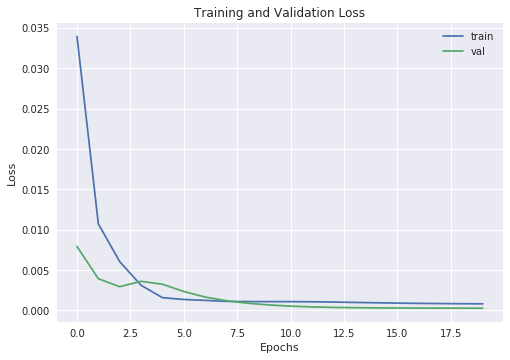

Test RMSE: 1.268
Test RMSE/std_dev: 0.171
Test MAE: 0.764


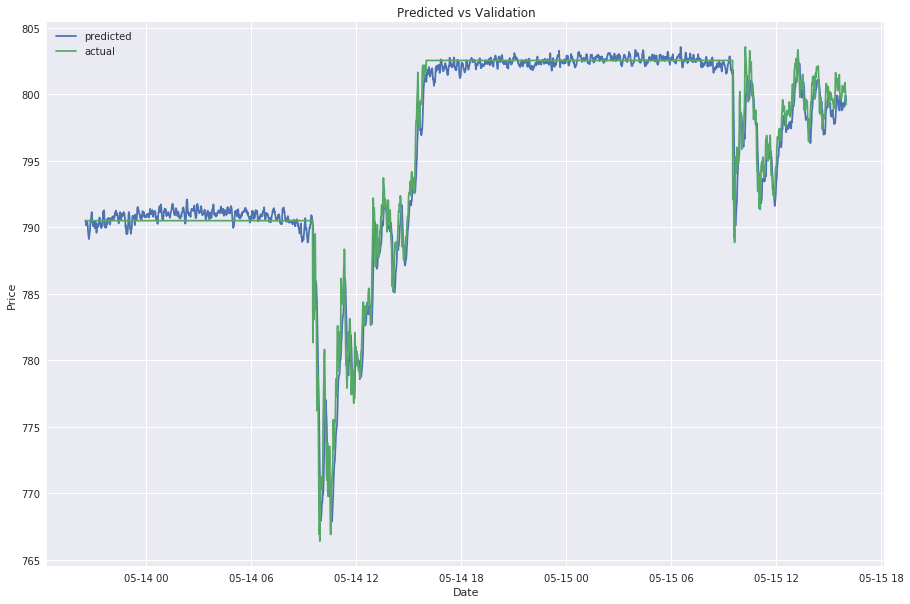

In [106]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(data.index[-2610:], y_pred, label='predicted')
    plt.plot(data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM
- 64-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(3060, 1080) 3060 (3060,)
(3060, 270, 4) (3060,) (3090, 270, 4) (3090,)
Epoch 1/20
48/48 - 7s - loss: 0.0369 - val_loss: 0.0142
Epoch 2/20
48/48 - 6s - loss: 0.0056 - val_loss: 0.0151
Epoch 3/20
48/48 - 6s - loss: 0.0047 - val_loss: 0.0118
Epoch 4/20
48/48 - 6s - loss: 0.0040 - val_loss: 0.0096
Epoch 5/20
48/48 - 6s - loss: 0.0032 - val_loss: 0.0080
Epoch 6/20
48/48 - 6s - loss: 0.0025 - val_loss: 0.0066
Epoch 7/20
48/48 - 6s - loss: 0.0020 - val_loss: 0.0053
Epoch 8/20
48/48 - 6s - loss: 0.0017 - val_loss: 0.0042
Epoch 9/20
48/48 - 6s - loss: 0.0015 - val_loss: 0.0037
Epoch 10/20
48/48 - 6s - loss: 0.0015 - val_loss: 0.0034
Epoch 11/20
48/48 - 6s - loss: 0.0014 - val_loss: 0.0032
Epoch 12/20
48/48 - 6s - loss: 0.0015 - val_loss: 0.0031
Epoch 13/20
48/48 - 7s - loss: 0.0016 - val_loss: 0.0030
Epoch 14/20
48/48 - 6s - loss: 0.0017 - val_loss: 0.0029
Epoch 15/20
48/48 - 6s - loss: 0.0018 - val_loss: 0.0026
Epoch 16/20
48/48 - 7s - loss: 0.0019 - val_loss: 0.0023
Epoch 17/20
48/48 - 6s - 

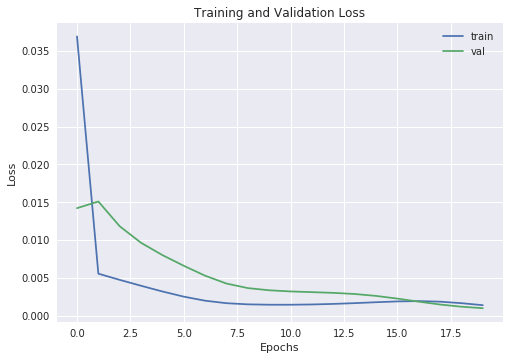

Test RMSE: 2.386
Test RMSE/std_dev: 0.308
Test MAE: 2.066


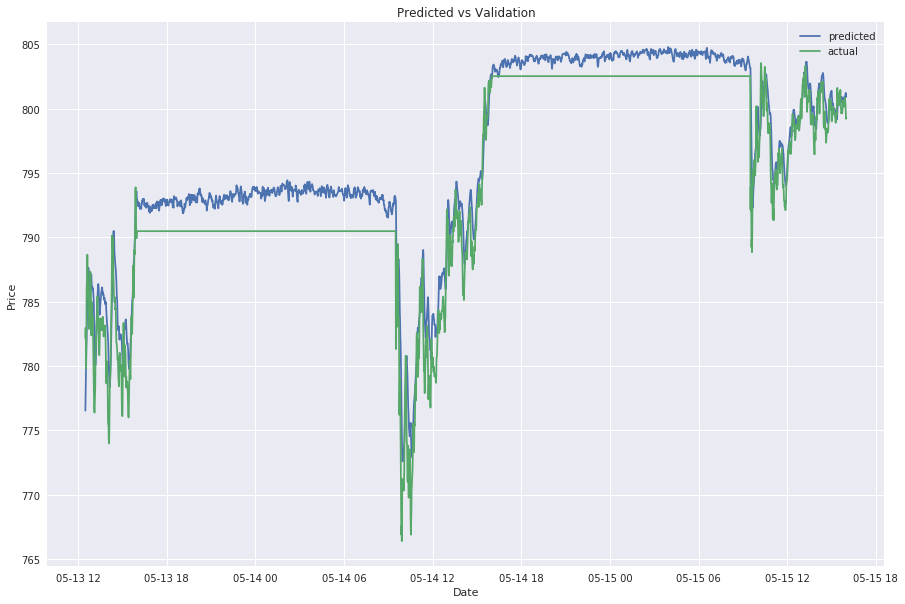

In [109]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 08:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(data.index[-3090:], y_pred, label='predicted')
    plt.plot(data.index[-3090:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM
- 64-dimensional single layer
- activation=relu
- epochs = 20
- batch size = 64
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 6s - loss: 0.0457 - val_loss: 0.0048
Epoch 2/20
56/56 - 5s - loss: 0.0075 - val_loss: 0.0044
Epoch 3/20
56/56 - 5s - loss: 0.0073 - val_loss: 0.0035
Epoch 4/20
56/56 - 5s - loss: 0.0056 - val_loss: 0.0033
Epoch 5/20
56/56 - 5s - loss: 0.0038 - val_loss: 0.0036
Epoch 6/20
56/56 - 5s - loss: 0.0026 - val_loss: 0.0029
Epoch 7/20
56/56 - 5s - loss: 0.0016 - val_loss: 0.0019
Epoch 8/20
56/56 - 5s - loss: 0.0012 - val_loss: 9.4792e-04
Epoch 9/20
56/56 - 5s - loss: 9.6223e-04 - val_loss: 4.2913e-04
Epoch 10/20
56/56 - 6s - loss: 9.2996e-04 - val_loss: 6.0479e-04
Epoch 11/20
56/56 - 5s - loss: 9.6323e-04 - val_loss: 4.1420e-04
Epoch 12/20
56/56 - 5s - loss: 8.0420e-04 - val_loss: 5.4162e-04
Epoch 13/20
56/56 - 5s - loss: 9.1707e-04 - val_loss: 4.6799e-04
Epoch 14/20
56/56 - 5s - loss: 0.0010 - val_loss: 5.0476e-04
Epoch 15/20
56/56 - 5s - loss: 0.0012 - val_loss: 6.2194e-04
Epoch 16/20
56/56 - 5s - loss:

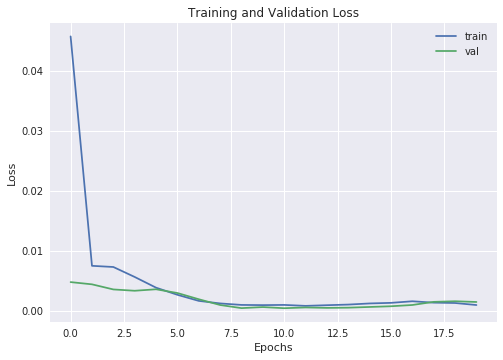

Test RMSE: 2.892
Test RMSE/std_dev: 0.390
Test MAE: 2.510


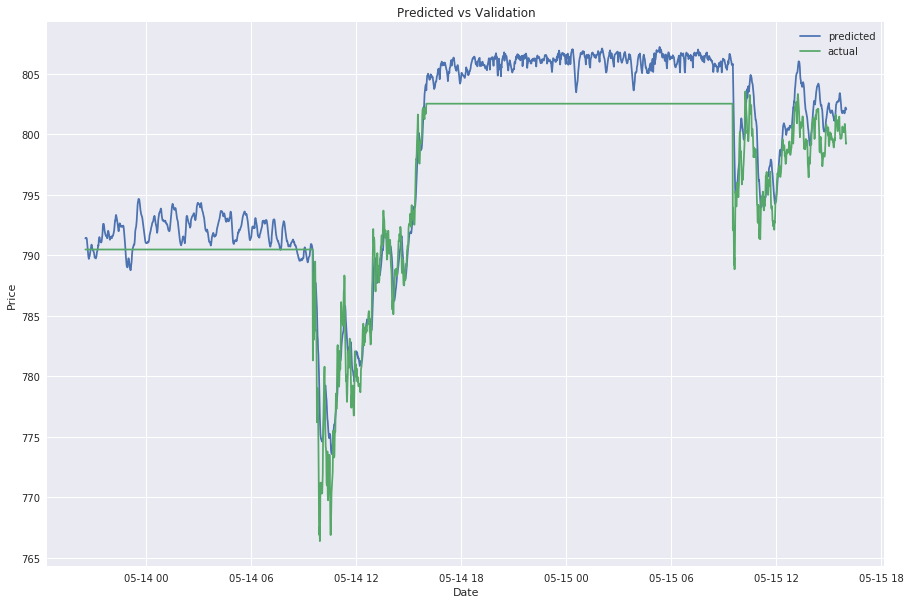

In [110]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(data.index[-2610:], y_pred, label='predicted')
    plt.plot(data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM
- 128-dimensional layer, 64-dimensional layer
- activation=tanh
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
14/14 - 14s - loss: 0.0350 - val_loss: 0.0048
Epoch 2/20
14/14 - 14s - loss: 0.0143 - val_loss: 0.0023
Epoch 3/20
14/14 - 14s - loss: 0.0177 - val_loss: 0.0079
Epoch 4/20
14/14 - 14s - loss: 0.0066 - val_loss: 0.0040
Epoch 5/20
14/14 - 14s - loss: 0.0037 - val_loss: 0.0017
Epoch 6/20
14/14 - 14s - loss: 0.0025 - val_loss: 5.9444e-04
Epoch 7/20
14/14 - 14s - loss: 0.0011 - val_loss: 4.3717e-04
Epoch 8/20
14/14 - 14s - loss: 0.0011 - val_loss: 4.7037e-04
Epoch 9/20
14/14 - 14s - loss: 0.0014 - val_loss: 4.5802e-04
Epoch 10/20
14/14 - 15s - loss: 0.0013 - val_loss: 4.4832e-04
Epoch 11/20
14/14 - 15s - loss: 0.0011 - val_loss: 4.2293e-04
Epoch 12/20
14/14 - 14s - loss: 9.9921e-04 - val_loss: 4.1796e-04
Epoch 13/20
14/14 - 14s - loss: 9.7781e-04 - val_loss: 4.4903e-04
Epoch 14/20
14/14 - 14s - loss: 0.0010 - val_loss: 5.0662e-04
Epoch 15/20
14/14 - 15s - loss: 0.0011 - val_loss: 5.8443e-04
Epoch 16/20
14/14 -

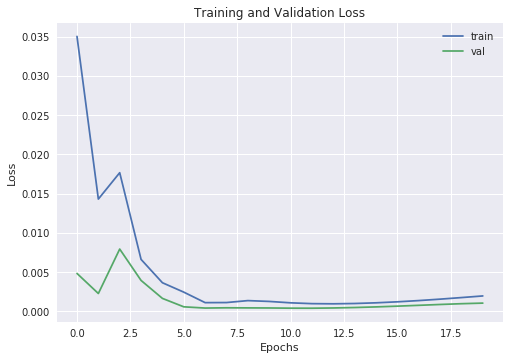

Test RMSE: 2.479
Test RMSE/std_dev: 0.335
Test MAE: 2.194


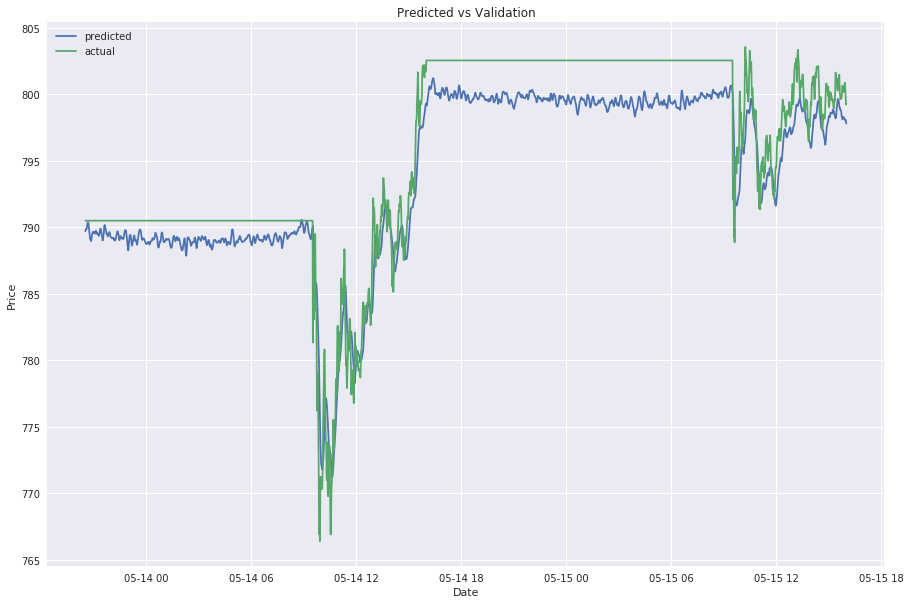

In [111]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=256, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(data.index[-2610:], y_pred, label='predicted')
    plt.plot(data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM
- 100-dimensional single layer
- activation = tanh
- epochs = 20
- batch size = 64

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 9s - loss: 0.0280 - val_loss: 0.0041
Epoch 2/20
56/56 - 9s - loss: 0.0060 - val_loss: 0.0048
Epoch 3/20
56/56 - 9s - loss: 0.0037 - val_loss: 0.0062
Epoch 4/20
56/56 - 9s - loss: 0.0022 - val_loss: 0.0046
Epoch 5/20
56/56 - 9s - loss: 0.0019 - val_loss: 0.0033
Epoch 6/20
56/56 - 9s - loss: 0.0017 - val_loss: 0.0023
Epoch 7/20
56/56 - 9s - loss: 0.0017 - val_loss: 0.0016
Epoch 8/20
56/56 - 9s - loss: 0.0016 - val_loss: 0.0011
Epoch 9/20
56/56 - 9s - loss: 0.0016 - val_loss: 7.6457e-04
Epoch 10/20
56/56 - 9s - loss: 0.0014 - val_loss: 5.4131e-04
Epoch 11/20
56/56 - 9s - loss: 0.0013 - val_loss: 4.1293e-04
Epoch 12/20
56/56 - 9s - loss: 0.0012 - val_loss: 3.4724e-04
Epoch 13/20
56/56 - 9s - loss: 0.0011 - val_loss: 3.1494e-04
Epoch 14/20
56/56 - 10s - loss: 0.0010 - val_loss: 2.9853e-04
Epoch 15/20
56/56 - 10s - loss: 9.8610e-04 - val_loss: 2.8978e-04
Epoch 16/20
56/56 - 10s - loss: 9.5902e-04 - val

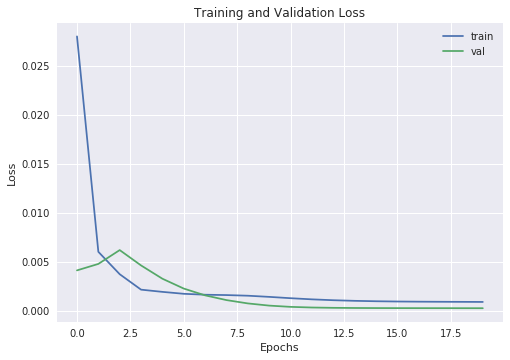

Test RMSE: 1.260
Test RMSE/std_dev: 0.170
Test MAE: 0.767


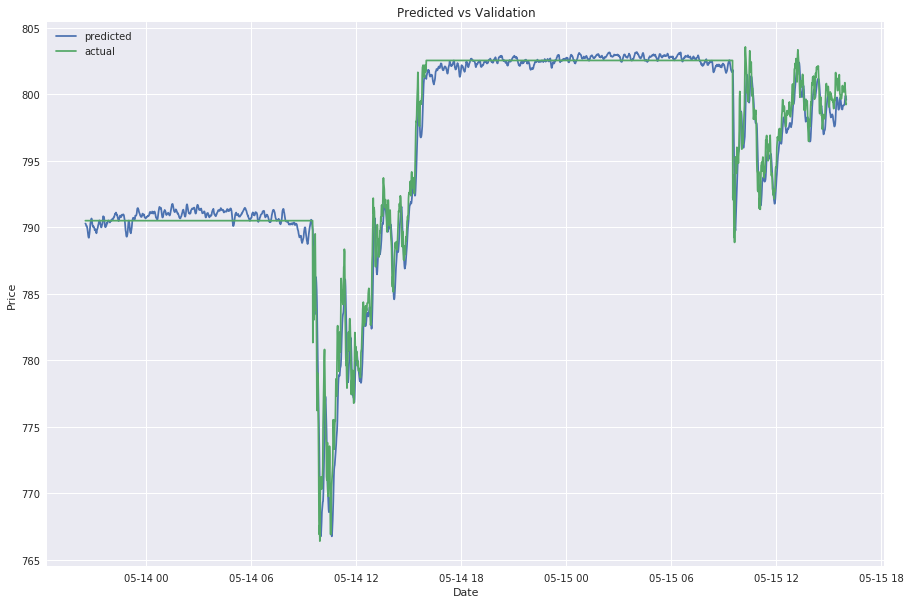

In [112]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(data.index[-2610:], y_pred, label='predicted')
    plt.plot(data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# Convolutional LSTM
- single 2D convolutional LSTM layer
- filters = 64
- kernel_size = (2,135)
- activation = relu
- epochs = 20
- batch size = 32

(3540, 1080) 3540 (3540,)
(3540, 1, 3, 90, 4) (3540,) (2610, 1, 3, 90, 4) (2610,)
Epoch 1/20
56/56 - 75s - loss: 0.0670 - val_loss: 0.0253
Epoch 2/20
56/56 - 68s - loss: 0.0568 - val_loss: 0.0128
Epoch 3/20
56/56 - 69s - loss: 0.0214 - val_loss: 0.0092
Epoch 4/20
56/56 - 67s - loss: 0.0235 - val_loss: 0.0078
Epoch 5/20
56/56 - 67s - loss: 0.0356 - val_loss: 0.0252
Epoch 6/20
56/56 - 67s - loss: 0.0302 - val_loss: 0.0306
Epoch 7/20
56/56 - 66s - loss: 0.0246 - val_loss: 0.0223
Epoch 8/20
56/56 - 67s - loss: 0.0278 - val_loss: 0.0190
Epoch 9/20
56/56 - 67s - loss: 0.0280 - val_loss: 0.0271
Epoch 10/20
56/56 - 67s - loss: 0.0230 - val_loss: 0.0194
Epoch 11/20
56/56 - 67s - loss: 0.0212 - val_loss: 0.0078
Epoch 12/20
56/56 - 67s - loss: 0.0233 - val_loss: 0.0173
Epoch 13/20
56/56 - 67s - loss: 0.0212 - val_loss: 0.0201
Epoch 14/20
56/56 - 68s - loss: 0.0191 - val_loss: 0.0120
Epoch 15/20
56/56 - 67s - loss: 0.0199 - val_loss: 0.0122
Epoch 16/20
56/56 - 67s - loss: 0.0206 - val_loss: 0.0182

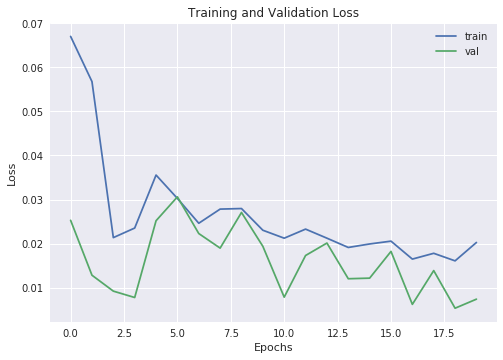

Test RMSE: 6.481
Test RMSE/std_dev: 0.875
Test MAE: 5.326


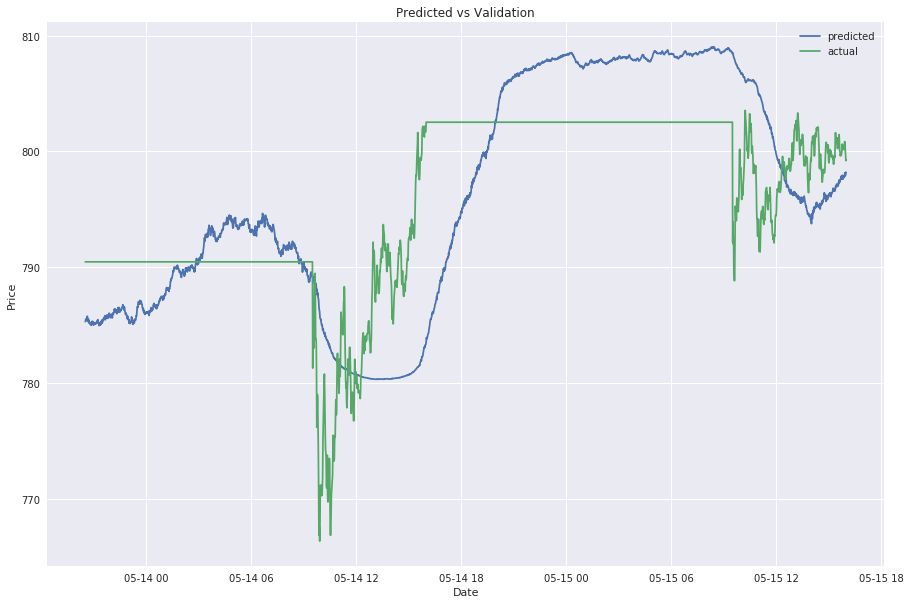

In [113]:
## load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1 ,3, 90, 4))
test_X = test_X.reshape((test_X.shape[0], 1, 3, 90, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.ConvLSTM2D(filters=128, kernel_size=(3,90), input_shape=(train_X.shape[1], 3, 90, 4)))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
y_pred = y_pred.reshape(y_pred.shape[0],1)
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(data.index[-2610:], y_pred, label='predicted')
    plt.plot(data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()